# Toy example

In [1]:
import torch
from torch import nn
from einops import rearrange, einsum
import einx
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from gptopt.gpt_model import apply_rotary_pos_emb, RotaryEmbedding

In [2]:
# Torch
seed = 0
torch.manual_seed(seed)
# NumPy
import numpy as np
np.random.seed(seed)
# Python
import random
random.seed(seed)

In [3]:
def plot_logs(logging):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
    
    for ax, key, ylabel, title in [
        (ax1, "loss", "Loss", "Training Loss"),
        (ax2, "max_abs_s", r"$\max_{ij}(K^\top Q)_{ij}$", "Max Attention Score"),
        (ax3, "s_delta", r"$\max_{j}\alpha_j$", r"$\Delta$"),
    ]:
        ax.plot(logging[key], label=key)
        ax.set(xlabel="Step", ylabel=ylabel, title=title)
        ax.set_yscale("log")
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

In [4]:
# -----------------------
# Self-attention with Wv = I, Wo = gamma * I
# -----------------------
class ToyAttention(nn.Module):
    def __init__(self, d_in: int, d_qk: int, enable_gamma=False):
        super().__init__()
        self.to_qk = nn.Linear(d_in, 2 * d_qk, bias=False)  # produces q and k
        self.scale = d_qk ** -0.5
        self.rope = RotaryEmbedding(d_qk, base=10000.0)
        device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda")
        if enable_gamma:
            self.gamma = nn.Parameter(torch.ones(1, device=device))  # output scaling
        else:
            self.gamma = 1.0

    def forward(self, x: torch.Tensor):
        """
        x: (B,T,d_in)
        out_t = sum_{i<=t} alpha_{t,i} x_i
        """
        qk = self.to_qk(x)         # (B,T, 2*d_qk)
        q, k = rearrange(qk, "b t (two d) -> two b t d", two=2)  # (2,B,T,d_qk) 
        T = x.size(1)
        cos, sin = self.rope.get_embed(T, x.device, x.dtype) 
        q = apply_rotary_pos_emb(q.unsqueeze(1), cos, sin).squeeze(1)
        k = apply_rotary_pos_emb(k.unsqueeze(1), cos, sin).squeeze(1)

        # key-query logits s_{t,i} = <q_t, k_i>/sqrt(d_qk)
        scores = torch.einsum("btd, bid -> bti", q, k) * self.scale  # (B,T,T)

        # causal mask: disallow i>t 
        mask = torch.triu(torch.ones(T, T, device=x.device, dtype=torch.bool), diagonal=1)
        scores = scores.masked_fill(mask, float("-inf"))

        attn = scores.softmax(dim=-1)                 # (B,T,T)
        out  = self.gamma * torch.einsum("bti, bid -> btd", attn, x)  # values are x (Wv=I, Wo=I)
        return out, scores, attn



In [5]:
# -----------------------
# Toy data (z_1,...,z_T,y)
# -----------------------
@torch.no_grad()
def sample_toy_batch(batch_size: int, T: int, V: int, rho: float, device=None):
    """
    z_1,...,z_T ~ Uniform({0,...,V-1}) i.i.d.
    a ~ Bernoulli(1-rho)
    y = a*z1 + (1-a)*z2  -> y=z1 w.p. 1-rho, else y=z2 w.p. rho
    """
    z = torch.randint(0, V, (batch_size, T), device=device)  # token ids
    a = (torch.rand(batch_size, device=device) < (1 - rho))  # True w.p. 1-rho
    y = torch.where(a, z[:, 0], z[:, 1])                     # class ids in [0, V-1]
    return z, y



# -----------------------
# End-to-end toy model (one-hot x_t in R^V so logits are in R^V)
# -----------------------
class ToyModel(nn.Module):
    def __init__(self, V: int, d_qk: int = 32):
        super().__init__()
        self.V = V
        self.attn = ToyAttention(d_in=V, d_qk=d_qk)

    def forward(self, z: torch.Tensor, return_aux: bool = False):
        # X in R^{B x T x V}
        x = F.one_hot(z, num_classes=self.V).float()

        x_attn, scores, attn = self.attn(x)
        xi = x_attn                   # xi_t = x'_t
        logits = xi[:, -1, :]         # predict y from last position (B,V)
        # print(x_attn.shape, logits.shape)
        if return_aux:
            finite_scores = scores[torch.isfinite(scores)]
            max_abs_s = finite_scores.abs().max().item() 
            max_s = finite_scores.max().item()
            min_s = finite_scores.min().item()
            s_delta = max_s - min_s
            return logits, max_abs_s, attn.abs().max().item(), s_delta
        return logits

# Count parameters in a model
def count_params(model, trainable_only=True):
    return sum(p.numel() for p in model.parameters() if (p.requires_grad or not trainable_only))


# -----------------------
# Minimal training loop + logit growth tracking
# -----------------------
def train_demo(
    V=50, T=8, rho=0.001, d_qk=128,
    batch_size=256, steps=10000, lr=0.001, device=None, freq=100
):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model = ToyModel(V=V, d_qk=d_qk).to(device)
    # Example usage
    total = count_params(model, trainable_only=False)
    trainable = count_params(model, trainable_only=True)
    print(f"Total params: {total:,}  |  Trainable: {trainable:,}")

    opt = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.95, 0.95), weight_decay=0.0)
    logging = {"loss":[], "max_abs_s":[], "max_att":[], "s_delta":[]}

    for step in range(steps):
        opt.zero_grad() 
        z, y = sample_toy_batch(batch_size, T, V, rho, device=device)
        logits, max_abs_s, max_att, score_delta = model(z, return_aux=True)
        loss = F.cross_entropy(logits, y)

        
        loss.backward()
        logging["loss"].append(loss.item())
        logging["max_abs_s"].append(max_abs_s)
        logging["max_att"].append(max_att) 
        logging["s_delta"].append(score_delta)
        opt.step()

        if step % freq == 0: 
            print(f"step={step:04d}  loss={loss.item():.4e}  max|s|={max_abs_s:.4e}")
    return logging

In [6]:
V = 100
min_loss = float(-1 + np.log(np.exp(1) + V - 1))
min_loss

3.6222070492242677

# $y = z_1$, i.e., $\rho=0$

In [7]:
logging = train_demo(V=V, T=20, rho=0, d_qk=32, batch_size=64, steps=10000, lr=0.01, freq=1000)

Total params: 6,400  |  Trainable: 6,400
step=0000  loss=4.5576e+00  max|s|=1.3409e-02
step=1000  loss=3.6222e+00  max|s|=3.9773e+01
step=2000  loss=3.6222e+00  max|s|=5.9657e+01
step=3000  loss=3.6222e+00  max|s|=6.0606e+01
step=4000  loss=3.6222e+00  max|s|=6.2381e+01
step=5000  loss=3.6222e+00  max|s|=6.3568e+01
step=6000  loss=3.6222e+00  max|s|=6.5047e+01
step=7000  loss=3.6222e+00  max|s|=6.6579e+01
step=8000  loss=3.6222e+00  max|s|=6.9208e+01
step=9000  loss=3.6222e+00  max|s|=7.2116e+01


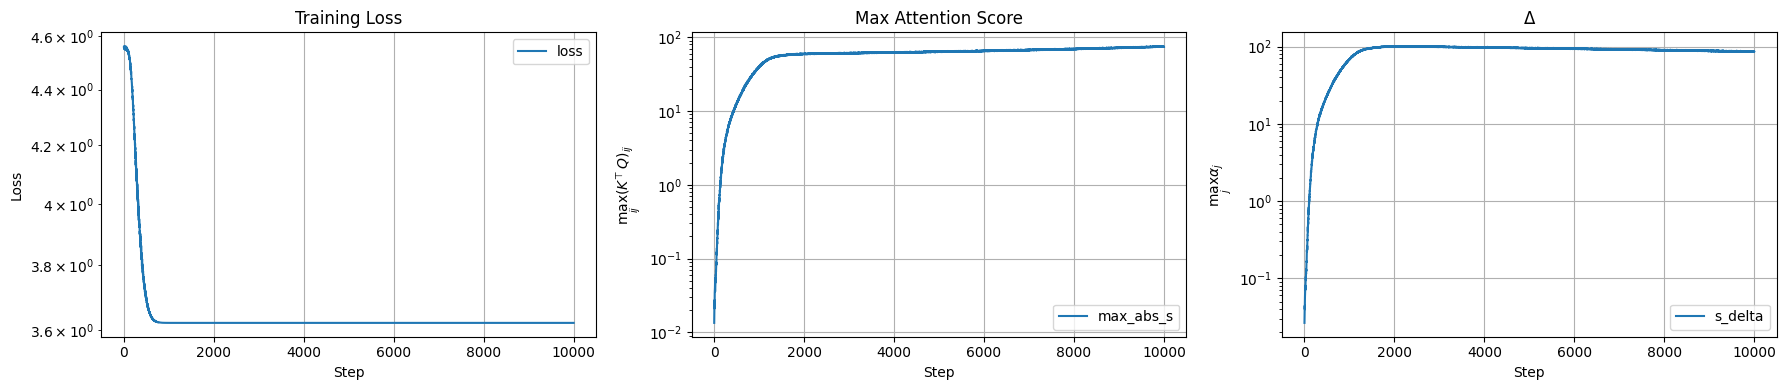

In [8]:
plot_logs(logging)

# $y = az_1 +(1-a)z_2, \quad a \sim \text{Bernoulli}(1-\rho), \quad \rho=10^{-5}$

In [9]:
rho = 1e-5

In [10]:
logging = train_demo(V=V, T=20, rho=rho, d_qk=32, batch_size=64, steps=10000, lr=0.01, freq=1000)

Total params: 6,400  |  Trainable: 6,400
step=0000  loss=4.5521e+00  max|s|=1.4442e-02
step=1000  loss=3.6223e+00  max|s|=3.8878e+01
step=2000  loss=3.6222e+00  max|s|=6.0097e+01
step=3000  loss=3.6222e+00  max|s|=6.1147e+01
step=4000  loss=3.6222e+00  max|s|=6.2220e+01
step=5000  loss=3.6222e+00  max|s|=6.3606e+01
step=6000  loss=3.6222e+00  max|s|=6.6584e+01
step=7000  loss=3.6222e+00  max|s|=6.7249e+01
step=8000  loss=3.6222e+00  max|s|=6.9889e+01
step=9000  loss=3.6222e+00  max|s|=7.2069e+01


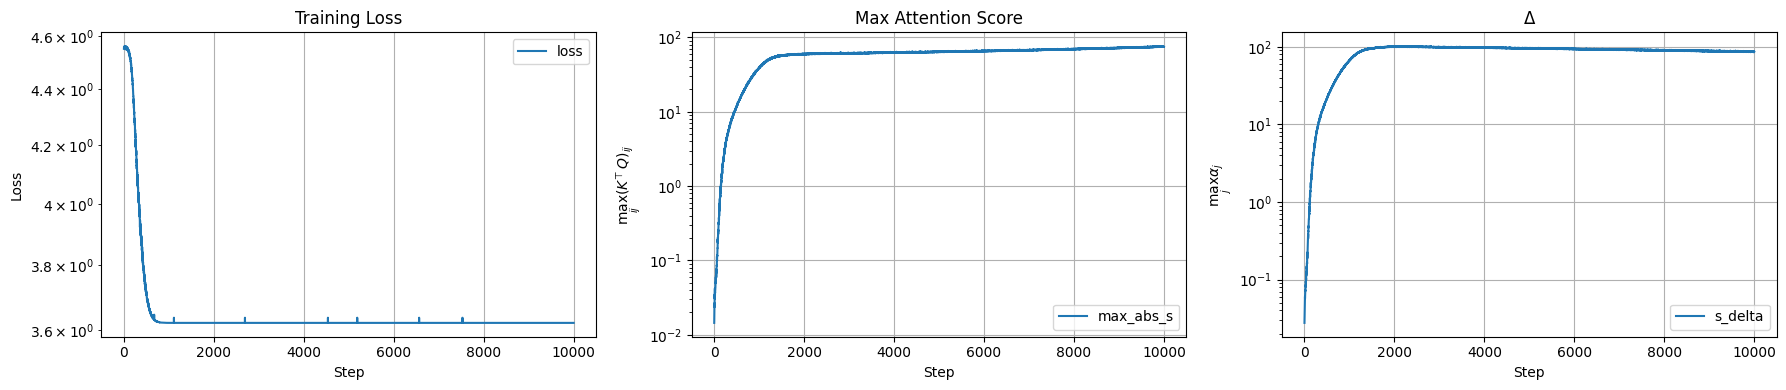

In [11]:
plot_logs(logging)